In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [2]:
# download the cases csv from github with pandas

# source: https://github.com/reichlab/covid19-forecast-hub/tree/master/data-truth
# hosp
# url = 'https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Hospitalizations.csv'
# cases
url= "https://media.githubusercontent.com/media/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Cases.csv"
epidata_df = pd.read_csv(url)
epidata_df = epidata_df[epidata_df['location'] == 'US'].set_index("date")["value"]
epidata_df.index = pd.to_datetime(epidata_df.index)
epidata_df

/var/folders/y5/jj4qlxkx619gkh07d2zt6h840000gn/T/ipykernel_41049/3190083228.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  epidata_df = pd.read_csv(url)


date
2020-01-22         1
2020-01-23         0
2020-01-24         1
2020-01-25         0
2020-01-26         3
               ...  
2023-01-24     53744
2023-01-25    100339
2023-01-26     62454
2023-01-27     17178
2023-01-28      3849
Name: value, Length: 1103, dtype: int64

In [3]:
import boto3, re
bucket = "idd-inference-runs"  # 'idd-inference-runs'
s3 = boto3.client("s3")
paginator = s3.get_paginator("list_objects_v2")
pages = paginator.paginate(Bucket=bucket, Prefix="", Delimiter="/")  # needs paginator cause more than 1000 files

prefixes = []
rundates = []
for page in pages:
    for cp in page["CommonPrefixes"]:
        prefix = cp["Prefix"]
        m = re.search(r"\d", prefix)
        try:
            timestamp = prefix[m.start() : m.start() + 8]
            rundate = datetime.datetime.strptime(timestamp, "%Y%m%d").date()
            if "test" not in prefix:
                rundates.append(rundate)
                prefixes.append(prefix)
        except:
            print("ERROR: ", prefix)

run_counts = pd.Series(rundates).value_counts().sort_index()
run_counts.index = pd.to_datetime(run_counts.index)
run_counts_w = run_counts.resample("W-SAT").sum()

ERROR:  USA-NA/


In [4]:
pref = [p[:2].lower() for p in prefixes]

In [5]:
locs = pd.Series(pref,index = rundates).sort_index()
locs[locs != "us"]

2020-05-14    mi
2020-05-14    mi
2020-05-14    mi
2020-05-14    mi
2020-05-15    we
              ..
2022-01-09    ca
2022-01-10    ca
2022-01-21    ca
2022-01-30    ca
2022-01-31    ca
Length: 479, dtype: object

In [42]:
# In case the above fails, e.g. because of missing internet connection
# use the following lists as fallback.


timeline = {
    "2020-02-02": ["First US COVID-19 death", "epi"],
    "2020-02-28": ["FlepiMoP debuts", "csp"],
    "2020-03-02": ["1st report to CDPH", "csp"],
    "2020-04-18": ["1st runs on AWS", "csp"], # In folder idd-pipeline-results, I think it was before but rephas without s3
    "2022-01-31": ["Last state (CA) specific run", "csp"],
   
# features: inference, vaccination, variants + age-structure, county runs, national runs.
    "2020-05-05": ["Added inference", "csp"], #>> git log --follow --format=%ad --date default R/scripts/filter_MC.R | tail -1   << gives ---Mon Apr 27 13:14:13 2020 -0400 but May 5 for operational
    "2021-01-13": ["Vaccination modeling", "csp"],
    "2021-06-04": ["Enable any compartmental structure", "csp"],
    "2022-02-01": ["gempyor as a package", "csp"],
    "2022-06-13": ["Adapted to Influenza", "csp"],   # github creation of Flu_USA
    "2022-09-23": ["Flu Scenario Modeling Hub R1", "csp"],   # github last R1 commit

# forecast Hubs, scenario hubs
 "2020-04-28": ["1st COVID-19 Forecast Hub runs", "csp"], # https://iddynamicsjhu.slack.com/archives/GU0SBC2AC/p1588097182025700
 "2021-01-08": ["COVID-19 Scenario Modeling Hub R1", "csp"], #https://github.com/midas-network/covid19-scenario-modeling-hub/tree/master/data-processed/JHU_IDD-CovidSP, Scenario defined as of 2020-12-22

}

timeline = pd.DataFrame.from_dict(timeline, orient='index', columns=['event', 'type'])
timeline.index.name = 'date'
timeline.sort_index(inplace=True)

names = timeline.event.to_list()
dates = timeline.index.to_list()
types = timeline.type.to_list()


# Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.datetime.strptime(d, "%Y-%m-%d") for d in dates]
timeline

,event,type
date,,
2020-02-02,First US COVID-19 death,epi
2020-02-28,FlepiMoP debuts,csp
2020-03-02,1st report to CDPH,csp
2020-04-18,1st runs on AWS,csp
2020-04-28,1st COVID-19 Forecast Hub runs,csp
2020-05-05,Added inference,csp
2021-01-08,COVID-19 Scenario Modeling Hub R1,csp
2021-01-13,Vaccination modeling,csp
2021-06-04,Enable any compartmental structure,csp


In [13]:
dates

array([-10,  10, -30,  30, -50,  50, -10,  10, -30,  30, -50,  50, -10])

/var/folders/y5/jj4qlxkx619gkh07d2zt6h840000gn/T/ipykernel_41049/2891563460.py:70: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


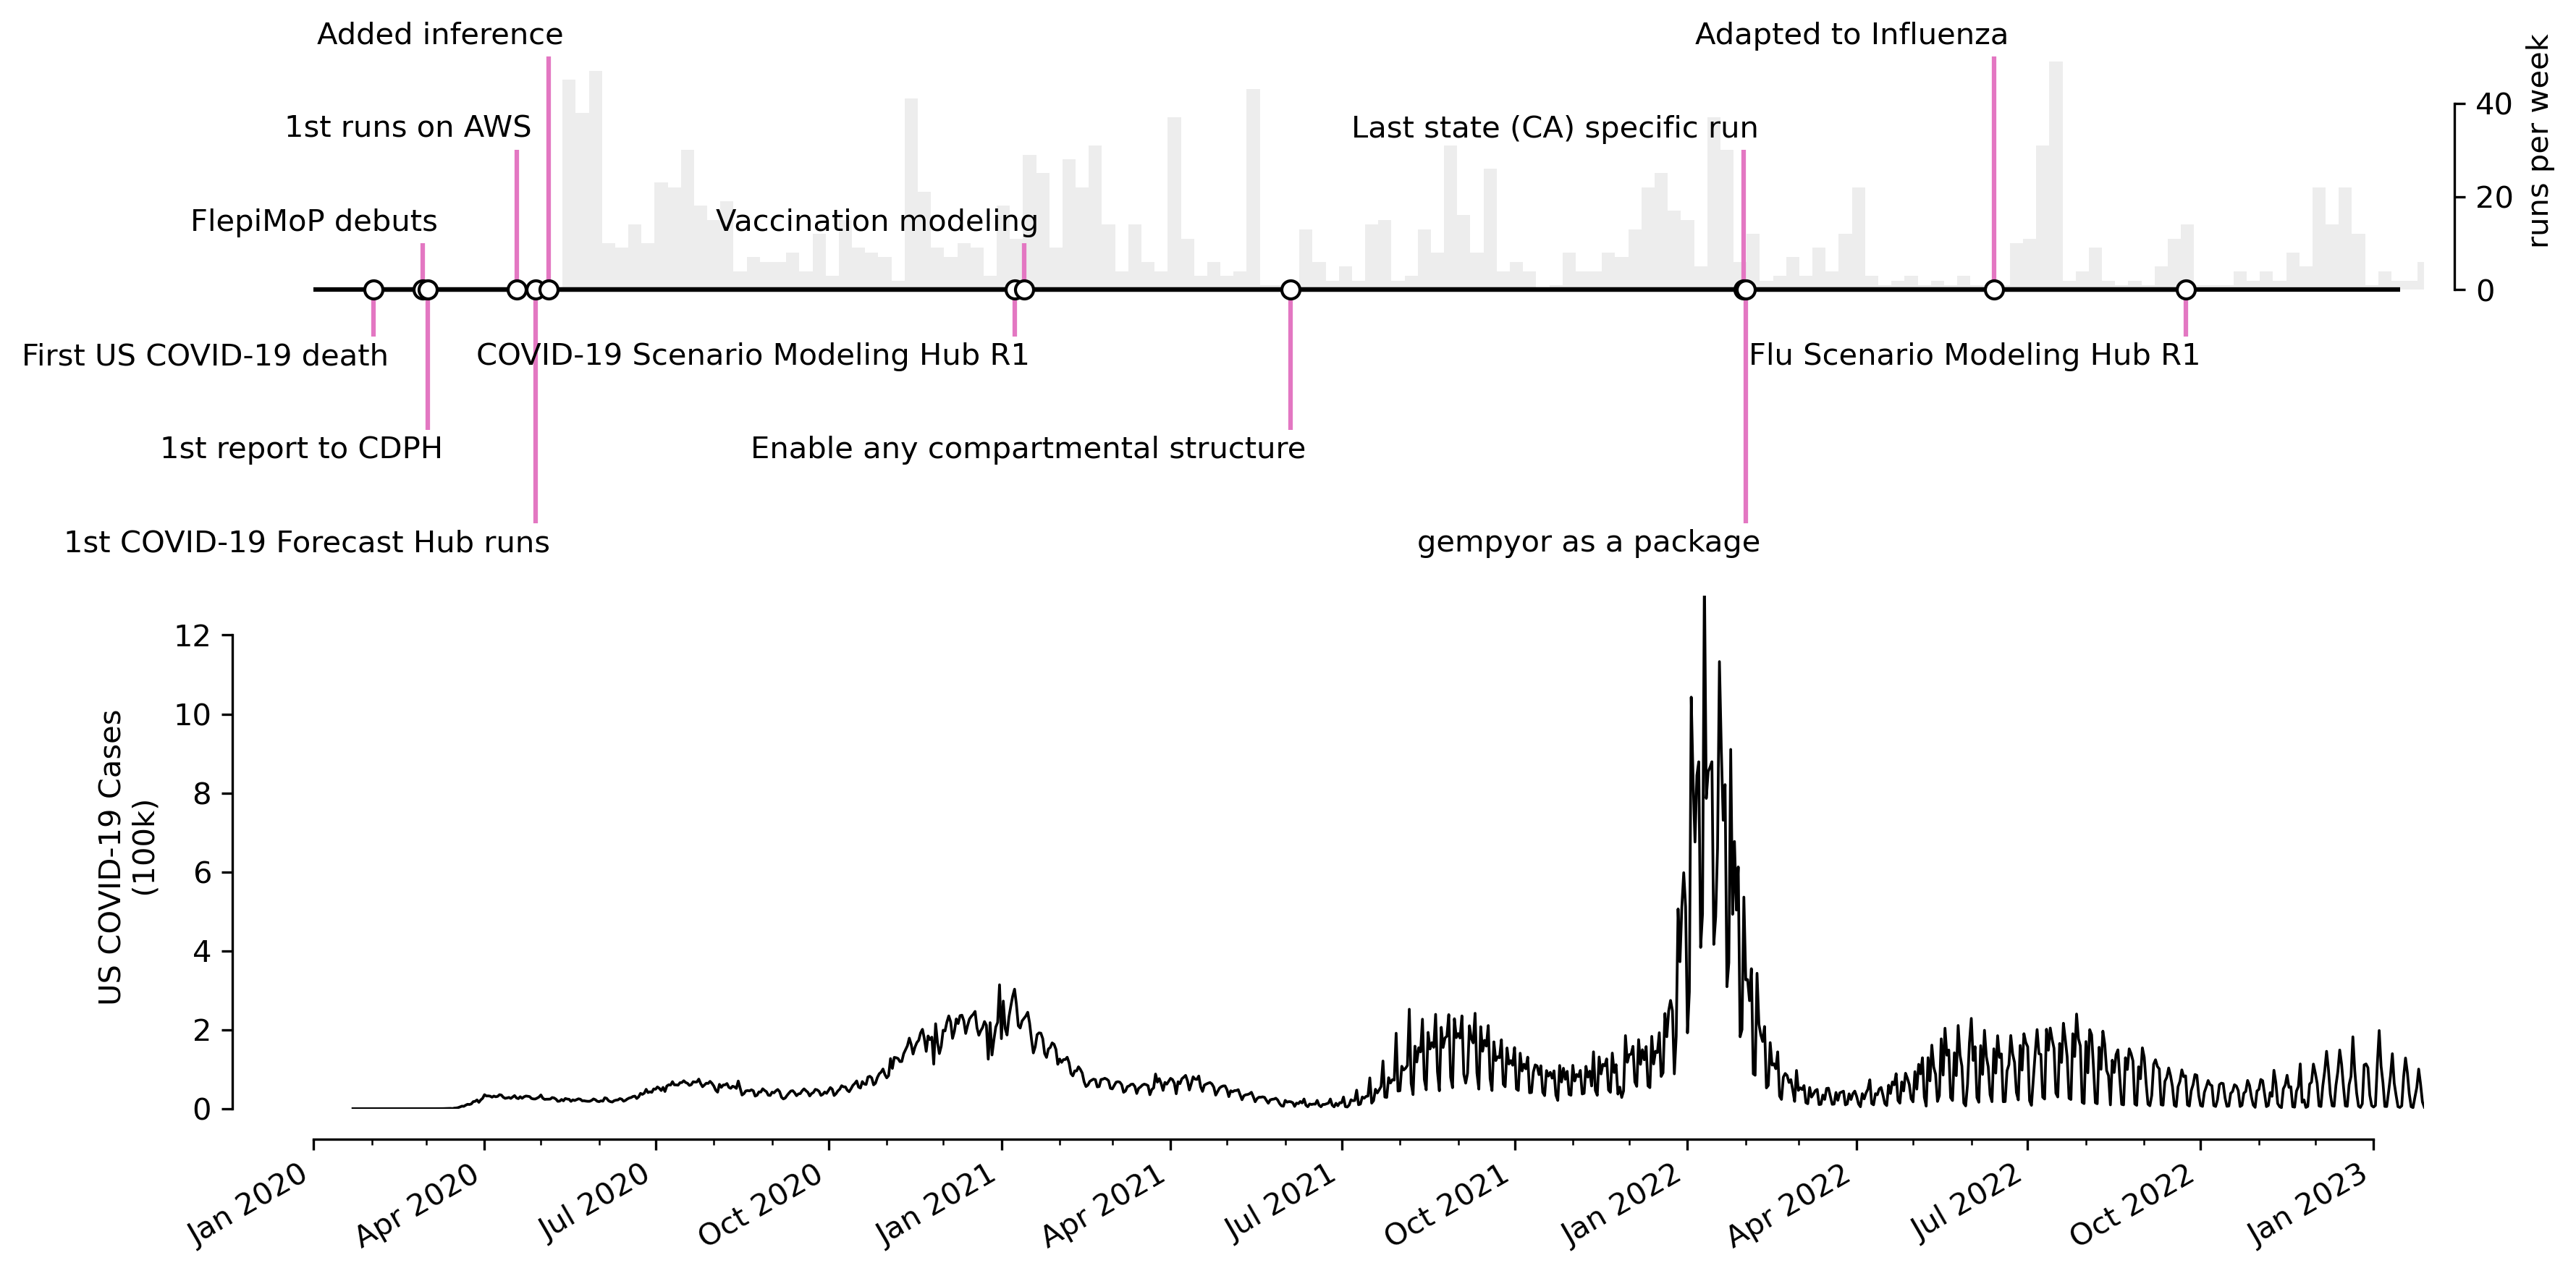

In [62]:
# Create figure and plot a stem plot with the date
fig, axes = plt.subplots(2,1, figsize=(12, 6), constrained_layout=True, sharex=True, dpi=300)

xlims = [datetime.date(2019,12,5), epidata_df.index[-1]]

ax = axes[0]

# plot the runs
ax.bar(run_counts_w.index, run_counts_w, width=7, color='lightgray', alpha=.4)

# Choose some nice levels
base_level = 0
scale_level = 10
pos1 = [-5, 5, -3, 3, -1, 1]
pos2 = [-1, 1, -3, 3, -5, 5]
levels = base_level + scale_level*np.tile(pos2,
                 int(np.ceil(len(dates)/6)))[:len(dates)]
markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C6-", basefmt="k-",
                                         use_line_collection=True, bottom=base_level)

ax.hlines(base_level, datetime.date(2020,1,1), datetime.date(2023,1,15), color="k", linestyles="-", lw=1.5)
plt.setp(markerline, mec="k", mfc="w", zorder=3)

# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(base_level * np.ones(len(dates)))
# annotate lines
vert = np.array(['top', 'bottom'])[(levels > base_level).astype(int)]
for d, l, r, va in zip(dates, levels, names, vert):
    ax.annotate(r, xy=(d, l), xytext=(5, np.sign(l-base_level)*2),
                textcoords="offset points", va=va, ha="right")
ax.set_yticks([0,20,40],["0","20","40"])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position('right')


sns.despine(offset=10, right=False, trim = True, ax=ax)
ax.set_ylabel("runs per week", loc="top")

for spine in [ "top", "left", "bottom"]:
    ax.spines[spine].set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)


#ax.margins(y=0.1)


ax = axes[1]
ax.plot(epidata_df/100000, c = 'k', lw='.9')

ax.set_xlim(xlims)
ax.set_ylim([0, 13])

for spine in ["right", "top",]:
    ax.spines[spine].set_visible(False)

sns.despine(offset = {"left" : 10, "bottom" : 10}, trim = True, ax=ax)

ax.xaxis.set_major_locator(mpl.dates.MonthLocator((1,4, 7, 10)))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
#ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%m--%Y'))
## format xaxis with 4 month intervals
# ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
# plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_ylabel("US COVID-19 Cases \n (100k)")

fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [75]:
markerline.set_c

/var/folders/y5/jj4qlxkx619gkh07d2zt6h840000gn/T/ipykernel_41049/2112470827.py:99: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.autofmt_xdate()


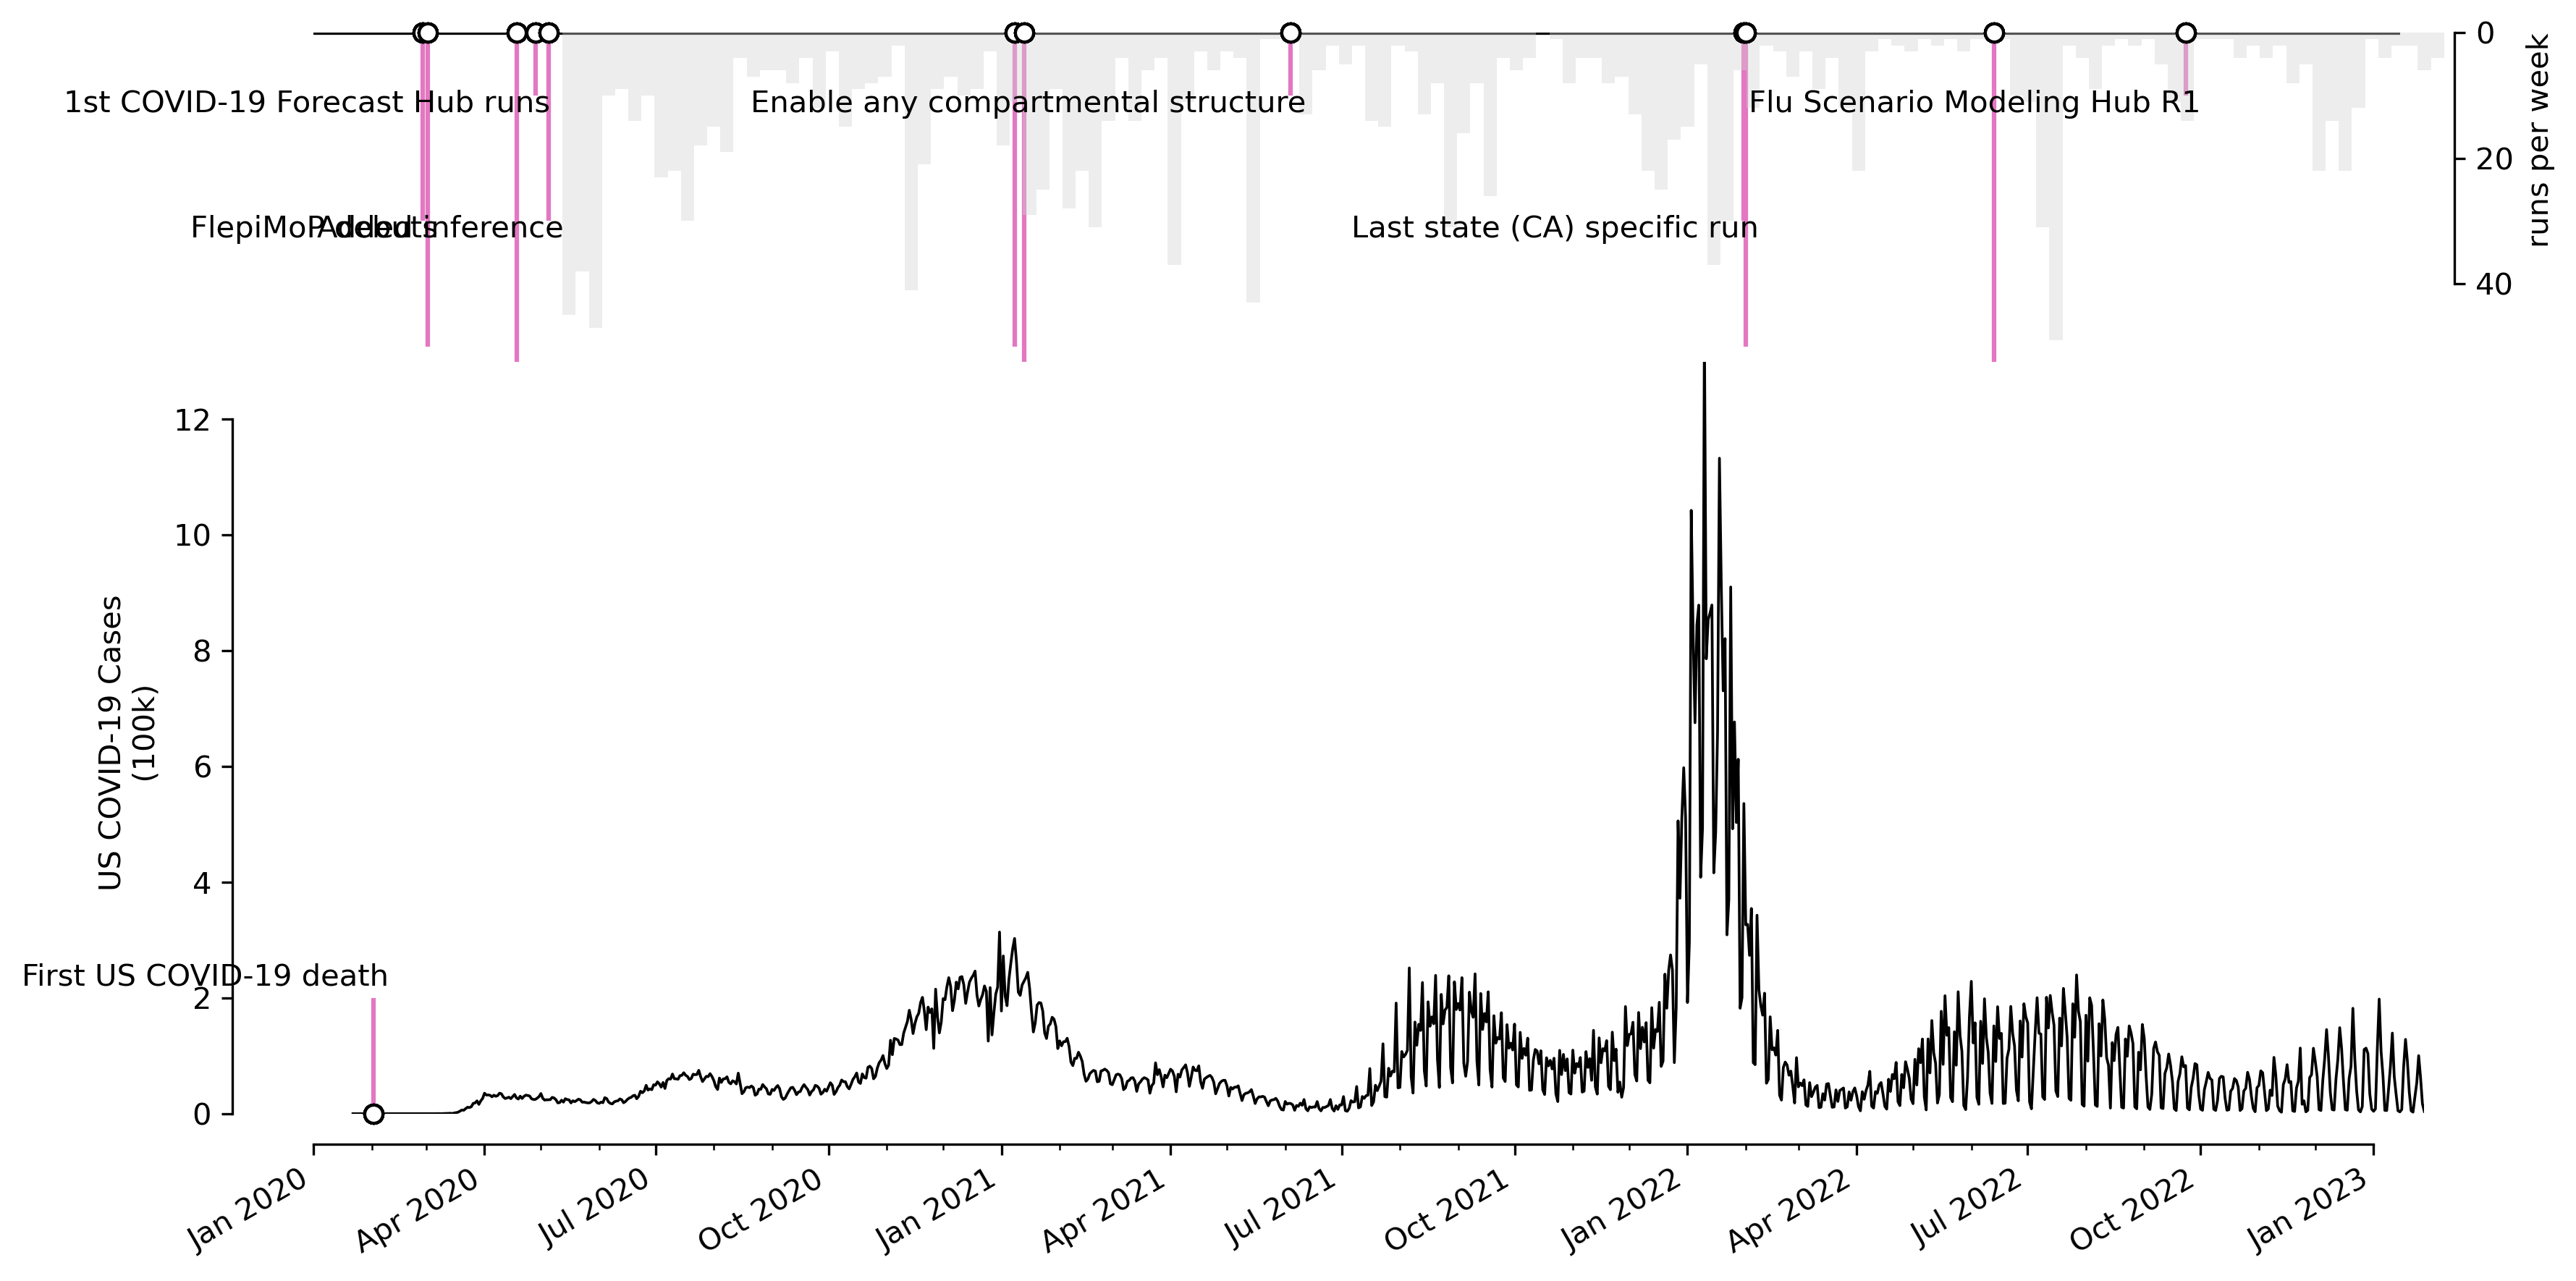

In [81]:
# Create figure and plot a stem plot with the date
fig, axes = plt.subplots(2,1, figsize=(12, 6), constrained_layout=True, sharex=True, dpi=300, gridspec_kw={'height_ratios': [1, 3]})

xlims = [datetime.date(2019,12,5), epidata_df.index[-1]]


def plot_one_stem(ax, date, name, base_level, level, inverted_axis=False):
    markerline, stemline, baseline = ax.stem(date, (level+base_level), bottom=base_level,
                                                    linefmt="C6-", basefmt="k-",
                                                    use_line_collection=True)
    markerline.set_clip_on(False)
    stemline.set_clip_on(False)
    baseline.set_clip_on(False)

        
    plt.setp(markerline, mec="k", mfc="w", clip_on=False, zorder=100)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(base_level * np.ones(len(dates)))
    # annotate lines
    if inverted_axis:
        vert = np.array(['bottom', 'top'])[(level > base_level).astype(int)]
    else:
        vert = np.array(['top', 'bottom'])[(level > base_level).astype(int)]

    ax.annotate(name, xy=(date, level), xytext=(5, np.sign(level-base_level)*2),
                textcoords="offset points", va=vert, ha="right", clip_on=False, zorder=100)


# prepare the stem plots


ax = axes[1]
# Choose some nice levels
base_level = 0
scale_level = 2
pos3 =[1,3,5]
pos = pos3
levels = base_level + scale_level*np.tile(pos,
                 int(np.ceil(len(dates)/len(pos))))[:len(dates)]
for i, (date, name, type) in enumerate(zip(dates, names, types)):
    if type == "epi":
        plot_one_stem(ax, date, name, base_level=(epidata_df/100000)[date], level=levels[i])

#ax.margins(y=0.1)

ax.plot(epidata_df/100000, c = 'k', lw='.9')

ax.set_xlim(xlims)
ax.set_ylim([0, 13])

for spine in ["right", "top",]:
    ax.spines[spine].set_visible(False)

sns.despine(offset = {"left" : 10, "bottom" : 10}, trim = True, ax=ax)

ax.xaxis.set_major_locator(mpl.dates.MonthLocator((1,4, 7, 10)))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())
#ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter('%m--%Y'))
## format xaxis with 4 month intervals
# ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
# plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.set_ylabel("US COVID-19 Cases \n (100k)")

ax = axes[0]
base_level = 0
scale_level = 10
pos3 =[1,3,5,7]
pos = pos3
levels = base_level + scale_level*np.tile(pos3,
                 int(np.ceil(len(dates)/len(pos))))[:len(dates)]


ax.hlines(base_level, datetime.date(2020,1,1), datetime.date(2023,1,15), color="k", linestyles="-", lw=1.5)
# plot the runs
ax.bar(run_counts_w.index, run_counts_w, width=7, color='lightgray', alpha=.4, clip_on=False, zorder=100)


for i, (date, name, type) in enumerate(zip(dates, names, types)):
    if type == "csp":
        plot_one_stem(ax, date, name, base_level, levels[i], inverted_axis=True)

ax.set_yticks([0,20,40],["0","20","40"])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position('right')
sns.despine(offset=10, right=False, trim = True, ax=ax)
ax.set_ylabel("runs per week", loc="top")

for spine in [ "top", "left", "bottom"]:
    ax.spines[spine].set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
ax.set_ylim([0,40])
ax.invert_yaxis()


fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [80]:
levels

array([10, 30, 50, 70, 10, 30, 50, 70])

In [16]:
(epidata_df/100000)[dates]

date
2020-02-02    0.00000
2020-02-28    0.00000
2020-03-02    0.00018
2020-04-18    0.27312
2020-04-28    0.24604
2020-05-05    0.24081
2021-01-08    3.02861
2021-01-13    2.28676
2021-06-04    0.17513
2022-01-31    5.36073
2022-02-01    3.26410
2022-06-13    1.51763
2022-09-23    0.83286
Name: value, dtype: float64